# Manejo de K-means con truco del núcleo
---

### Daniel Marín López

### Ejercicio

Usad los siguientes algoritmos:

1. K-means normal
2. K-means con truco del núcleo
3. DBSCAN
4. DPC

### Importación de librerías

In [1]:
!pip install pydpc
!pip install kneed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pydpc: filename=pydpc-0.1.3-cp311-cp311-linux_x86_64.whl size=252425 sha256=2d82c4b87c493828a41dd21f6cbd30c87fbb3025f3380b8b14d8a95504c5b73c
  Stored in directory: /root/.cache/pip/wheels/80/10/90/19dfe60b973612ce1865d872779b534264fd187995f84e0f90
Successfully built pydpc


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import pydpc
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics.pairwise import rbf_kernel

### Variables globales y funciones

In [10]:
Kmax = 11 # Número máximo de clusters
SEED = 42

In [4]:
def BIC(K, grupos, X):
  """
  K: Número de grupos (clusters)
  grupos: Vector que contiene los grupos de los datos
  X: Matriz de datos
  """
  N = X.shape[0] # Número de datos
  P = X.shape[1] # Número de variables
  xi = np.zeros((1,K)) # Vector xi

  # Calculamos el sumario de xi en la fórmula
  for k in range(0, K):
    suma = 0
    for j in range(0, P):
      sigma = np.square(np.std(X[:, j]))
      sigma_j = np.square(np.std(X[grupos==k, j]))
      suma += 0.5*np.log(sigma + sigma_j)

    n_k = sum(grupos==k) # Número de elementos en el grupo k
    xi[0, k] = -n_k*suma

  bic = -2*np.sum(xi) + 2*K*P*np.log(N)
  return bic

In [5]:
def Elbow_BIC_iter(Kmax=10, X=None, method='elbow'):
  """
  Kmax: Número máximo de clusters
  X: Matriz de datos
  method: Método de cálculo de BIC o Elbow
  """
  results = []
  K_range = range(1, Kmax)

  for k in K_range:
      kmeans = KMeans(n_clusters=k, random_state=SEED, n_init=10)
      if method == 'elbow':
        kmeans.fit(X)
        results.append(kmeans.inertia_)
      elif method == 'bic':
        grupos = kmeans.fit_predict(X)
        results.append(BIC(k, grupos, X))
      else:
        raise ValueError("El método debe ser 'elbow' o 'bic'")

  if method == 'bic':
    bic_k = np.argmin(results) + 1
    return K_range, results, bic_k
  else:
    kl = KneeLocator(K_range, results, curve="convex", direction="decreasing")
    elbow_k = kl.elbow
    return K_range, results, elbow_k

### 1. Carga de datos
---

Cargamos nuestro conjunto de datos.

In [6]:
data = pd.read_csv('synthetic_data4.csv')
data.head()

,X1,X2,Cluster
0,0.682988,-0.345203,1
1,2.040990,-0.131615,1
2,-0.139752,0.454391,1
3,0.885748,0.286342,0
4,1.182459,-0.497711,1


Y creamos la matriz `X` que no está etiquetada.

In [7]:
X = data.drop('Cluster', axis=1)
X.head()

,X1,X2
0,0.682988,-0.345203
1,2.040990,-0.131615
2,-0.139752,0.454391
3,0.885748,0.286342
4,1.182459,-0.497711


### 2. Escalado
---

Escalamos los datos.

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 3. Visualización
---

Hacemos una visualización de los datos.

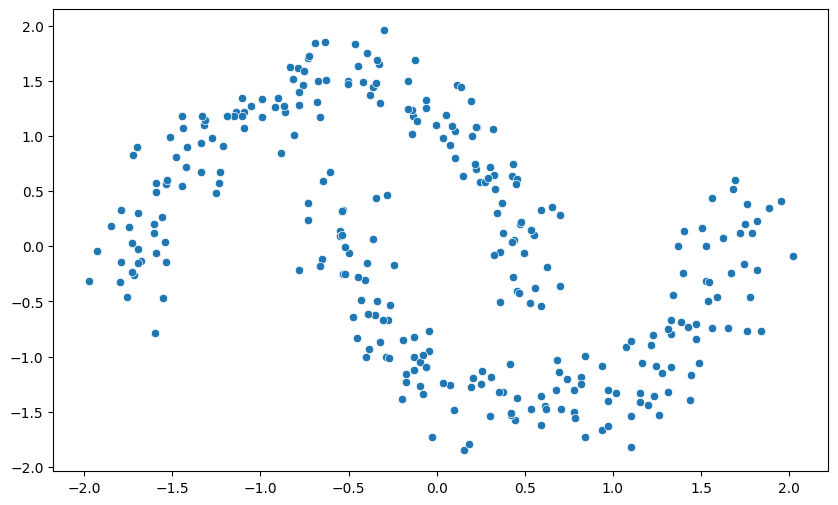

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1])
plt.show()

Y vemos dos conjuntos de datos que hacen una espiral, algo que K-means no podrá hacer probablemente.

### 4. K-means normal
---

Realizamos K-means como otras veces, sacamos el mejor K tanto con BIC como con la suma de las distancias al cuadrado para el codo.

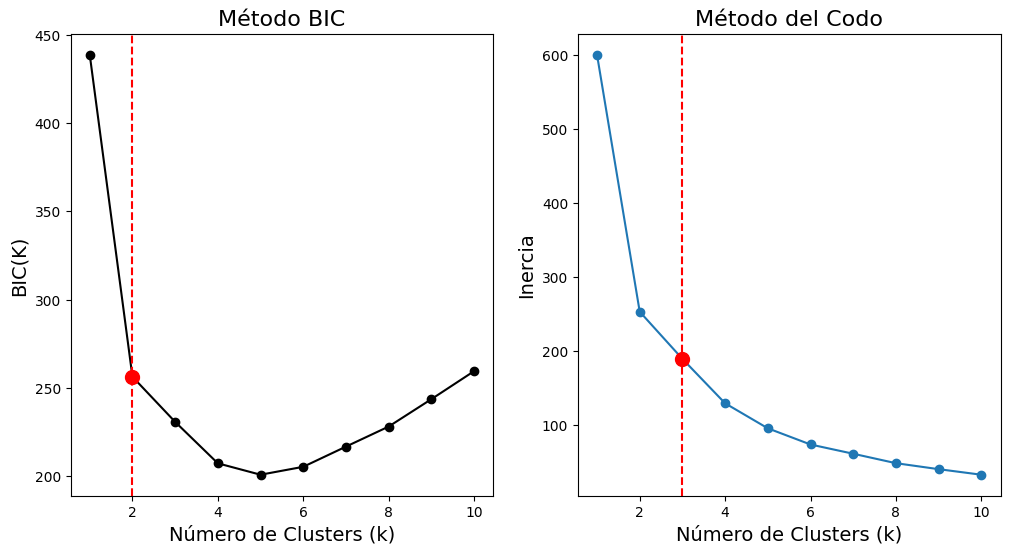

In [11]:
K_range, BIC_array, elbow_bic = Elbow_BIC_iter(Kmax, X_scaled, 'bic')
_, Elbow_array, elbow_in = Elbow_BIC_iter(Kmax, X_scaled, 'elbow')

# Dibujamos el BIC obtenido para cada valor de k
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(K_range, BIC_array, "ko-")
plt.title("Método BIC", fontsize=16)
plt.xlabel("Número de Clusters (k)", fontsize=14)
plt.ylabel("BIC(K)", fontsize=14)
plt.axvline(x=elbow_bic, linestyle="--", color="red", label=f'Codo en k={elbow_bic}')
plt.scatter(elbow_bic, BIC_array[elbow_bic - 1], color='red', s=100, zorder=3)

plt.subplot(1, 2, 2)
plt.plot(K_range, Elbow_array, marker='o')
plt.xlabel('Número de Clusters (k)', fontsize=14)
plt.ylabel('Inercia', fontsize=14)
plt.title('Método del Codo', fontsize=16)
plt.axvline(x=elbow_in, linestyle="--", color="red", label=f'Codo en k={elbow_in}')
plt.scatter(elbow_in, Elbow_array[elbow_in - 1], color='red', s=100, zorder=3)

plt.show()

Vemos que solo BIC llega a un K de 2, el cual es el adecuado. Lo siguiente será crear y entrenar el modelo para obtener los grupos y los centroides.

In [12]:
kmeans_model = KMeans(n_clusters=elbow_bic, random_state=SEED)
kmeans_model.fit(X_scaled)
grupos = kmeans_model.predict(X_scaled)
centroides = kmeans_model.cluster_centers_

print(f"BIC: {BIC(elbow_bic, grupos, X_scaled)}")
print(f"Inercia: {kmeans_model.inertia_}")

BIC: 256.3343184636009
Inercia: 252.68258395161033


Por último, visualizamos los resultados.

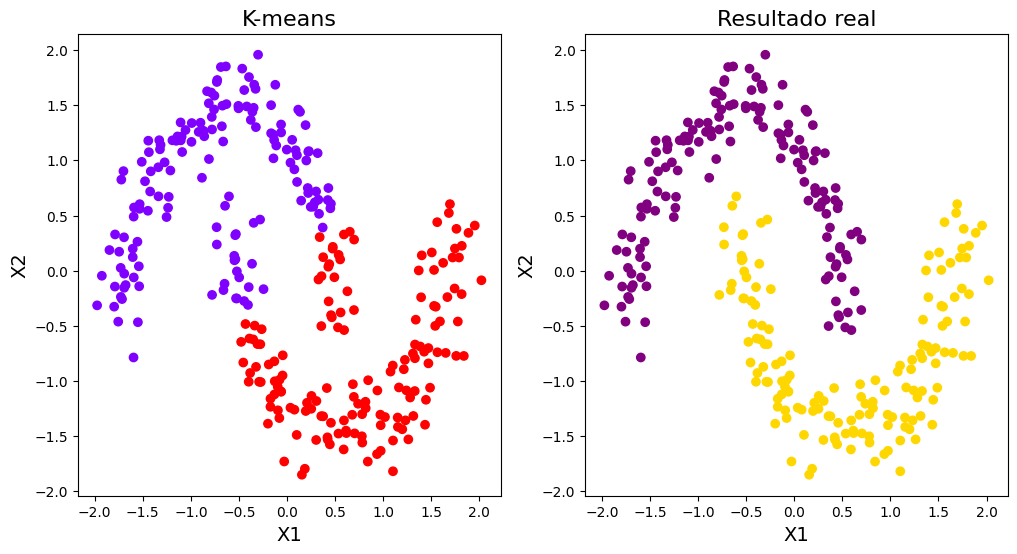

In [13]:
colores = ['purple', 'gold']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=grupos, cmap='rainbow')
plt.title('K-means', fontsize=16)
plt.xlabel('X1', fontsize=14)
plt.ylabel('X2', fontsize=14)

plt.subplot(1, 2, 2)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=[colores[i] for i in data['Cluster']])
plt.title('Resultado real', fontsize=16)
plt.xlabel('X1', fontsize=14)
plt.ylabel('X2', fontsize=14)

plt.show()

Vemos que, efectivamente, K-means no ha sido capaz de realizar la separación correctamente.

### 5. K-means con truco del núcleo
---

El truco del núcleo es una forma de que K-means pueda separar los dos grupos cambiando la dimensión, un poco parecido a lo que hacia SVM. Lo primero que haremos será calcular la matriz de Gam usando un núcleo Gaussiano.

> **OJO**: A la hora de hacer la matriz de Gam hemos usado los datos **sin escalar**. La razón es que al usar los datos escalados fallaba K-means de la misma forma que pasó anteriormente. Es por ello que es importante que la matriz no tenga los datos escalados.



In [14]:
Gram_matrix = rbf_kernel(data, gamma=1)

Y volvemos a realizar el entrenamiento.

In [16]:
kmeans_nucleo_model = KMeans(n_clusters=elbow_bic, random_state=SEED)
grupos_nucleo = kmeans_nucleo_model.fit_predict(Gram_matrix)
centroides_nucleo = kmeans_nucleo_model.cluster_centers_

print(f"BIC: {BIC(elbow_bic, grupos, Gram_matrix)}")
print(f"Inercia: {kmeans_nucleo_model.inertia_}")

BIC: -162062.13145664826
Inercia: 5101.060780549477


Ahora visualizamos los nuevos resultados.

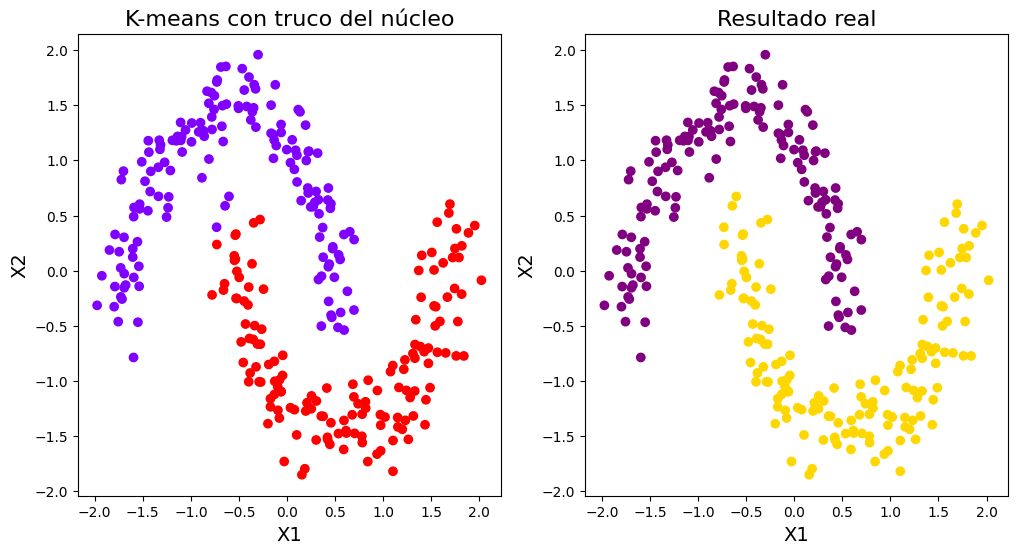

In [17]:
colores = ['purple', 'gold']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=grupos_nucleo, cmap='rainbow')
plt.title('K-means con truco del núcleo', fontsize=16)
plt.xlabel('X1', fontsize=14)
plt.ylabel('X2', fontsize=14)

plt.subplot(1, 2, 2)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=[colores[i] for i in data['Cluster']])
plt.title('Resultado real', fontsize=16)
plt.xlabel('X1', fontsize=14)
plt.ylabel('X2', fontsize=14)

plt.show()

Vemos que el truco del núcleo ha sido capaz de resolver el problema y separar los dos puntos en dos grupos. Solo hay tres puntos que no han sido clasificados correctamente.

### 6. DBSCAN
---

Usaremos `minPts` igual a 5 y `epsilon` igual a 0.3 cuyo resultado son 2 clústeres.

In [ ]:
minPts = 5
epsilon = 0.3

dbscan = DBSCAN(eps=epsilon, min_samples=minPts)
labels = dbscan.fit_predict(X_scaled)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

print ('Number of clusters %d' % n_clusters)

Number of clusters 2


Luego, visualizamos los resultados.

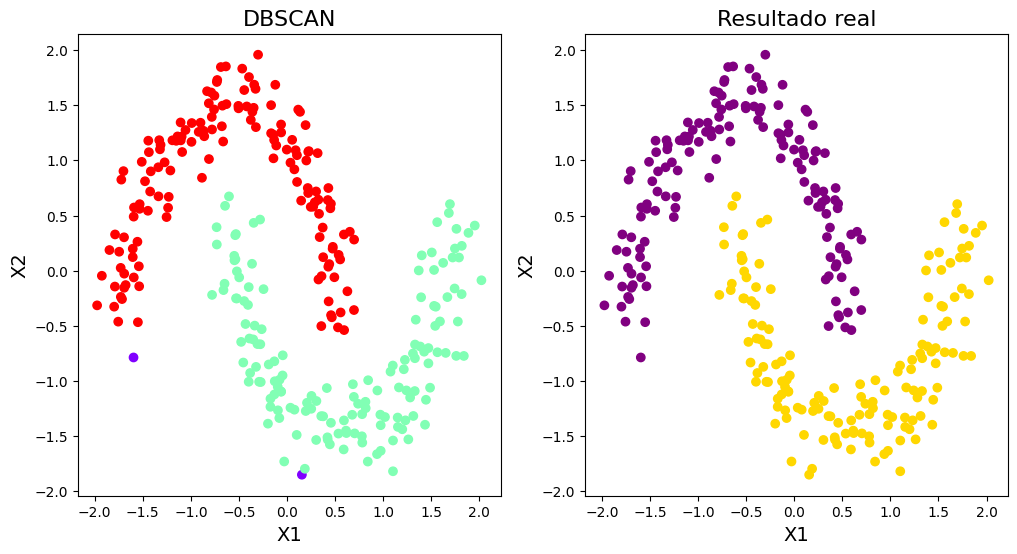

In [ ]:
colores = ['purple', 'gold']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='rainbow')
plt.title('DBSCAN', fontsize=16)
plt.xlabel('X1', fontsize=14)
plt.ylabel('X2', fontsize=14)

plt.subplot(1, 2, 2)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=[colores[i] for i in data['Cluster']])
plt.title('Resultado real', fontsize=16)
plt.xlabel('X1', fontsize=14)
plt.ylabel('X2', fontsize=14)

plt.show()

Vemos que DBSCAN ha conseguido realizar la separación, solamente hay dos outliers pero el resto está muy bien.

### DPC

Hacemos el cálculo de las densidades y las distancias mínimas. Volvemos a usar `np.ascontiguousarray` para que la función `pydpc.Cluster` funcione.



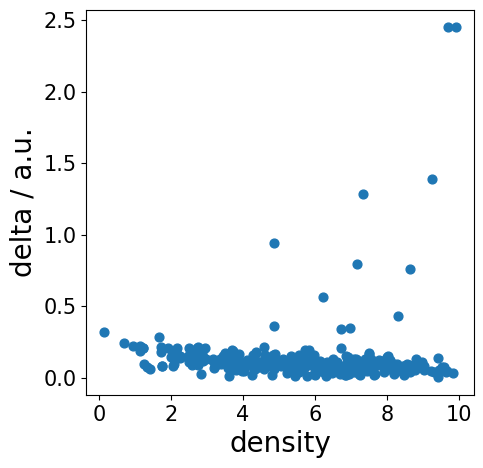

In [ ]:
clu = pydpc.Cluster(np.ascontiguousarray(X_scaled))

Definimos rho y delta para crear la frontera de los centroides.

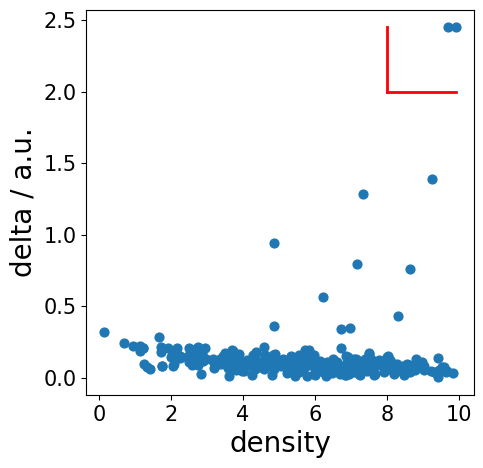

In [ ]:
np.bool = bool # Deprecated

rho = 8
delta = 2.0
clu.assign(rho, delta)

Sacamos los centroides y los labels para el resto de datos.

In [ ]:
cluster_centers = clu.clusters
cluster_centers

array([ 70, 128], dtype=int32)

In [ ]:
labels_dpc = clu.membership
labels_dpc

array([1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0], d

Y, por último, visualizamos los datos.

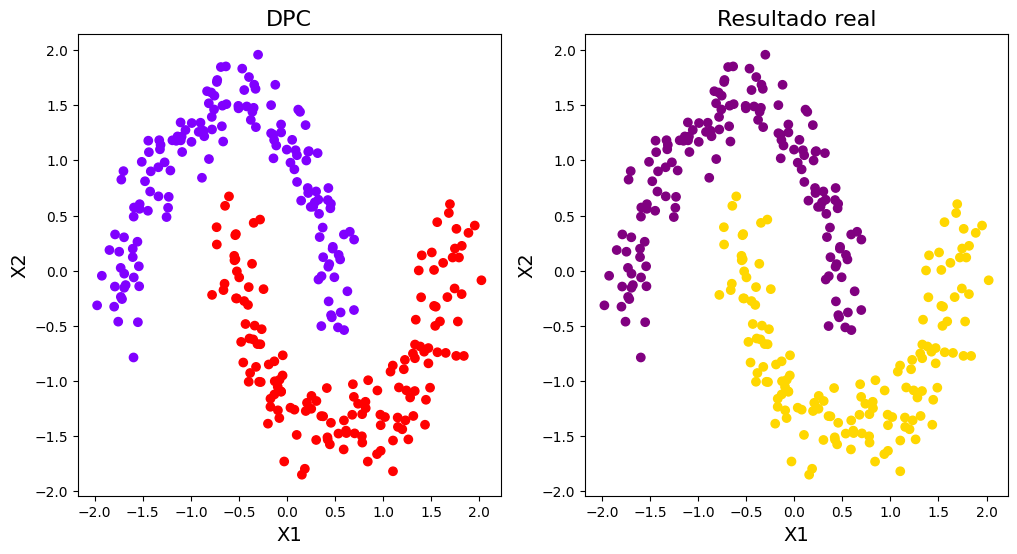

In [ ]:
colores = ['purple', 'gold']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_dpc, cmap='rainbow')
plt.title('DPC', fontsize=16)
plt.xlabel('X1', fontsize=14)
plt.ylabel('X2', fontsize=14)

plt.subplot(1, 2, 2)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=[colores[i] for i in data['Cluster']])
plt.title('Resultado real', fontsize=16)
plt.xlabel('X1', fontsize=14)
plt.ylabel('X2', fontsize=14)

plt.show()

Vemos que DPC ha hecho un trabajo impecable en la separación de los grupos y ni siquiera tiene outliers. Es por ello que considero este el mejor resultado de todos los obtenidos.